In [2]:
import os
import pandas as pd

In [42]:
hits = pd.read_csv("data/sf3.csv")
all = pd.read_csv("data/drugrepurposinghub.csv")
all = all.drop_duplicates(subset=["InChIKey"])
all = all.drop_duplicates(subset=["smiles"])
all.shape

(6599, 4)

In [38]:
#standardise hits

from rdkit import Chem
from standardiser import standardise

mols = [Chem.MolFromSmiles(s) for s in hits["SMILES"]]
hits["InChIKey"] = [Chem.MolToInchiKey(m) for m in mols ]

print(hits.shape)
smiles = []
mols = []
for s in hits["SMILES"]:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        try:
            mol_ = standardise.run(mol)
            s_ = Chem.MolToSmiles(mol_)
        except:
            print("Non standard:", s)
            s_ = None
    else:
        print("No rdkit:" ,s)
        s_ = None
    smiles += [s_]

hits["smiles_ok"] = smiles
hits_ok = hits[~hits["smiles_ok"].isna()]

(240, 19)
Non standard: CC[Hg]Sc1ccccc1C(O)=O
Non standard: O1[n+]2ccccc2S[Zn]11O[n+]2ccccc2S1
Non standard: CCCCCCc1ccc(O)cc1O.Nc1c2ccccc2nc2ccccc12
Non standard: CC(=O)OCC1=C2N3[C@H](SC1)[C@H](NC(=O)CCC[C@H](N)C(=O)O[Zn]OC2=O)C3=O |t:5|
Non standard: CN[C@H]1[C@H](O)[C@@H](O)[C@H](CO)O[C@H]1O[C@H]1[C@H](O[C@@H]2[C@@H](O)[C@H](O)[C@@H](NC(N)=N)[C@H](O)[C@H]2NC(N)=N)O[C@@H](C)[C@]1(O)CO.CN[C@H]1[C@H](O)[C@@H](O)[C@H](CO)O[C@H]1O[C@H]1[C@H](O[C@@H]2[C@@H](O)[C@H](O)[C@@H](NC(N)=N)[C@H](O)[C@H]2NC(N)=N)O[C@@H](C)[C@]1(O)CO
Non standard: Oc1ccc(cc1[N+]([O-])=O)[As](O)(O)=O
Non standard: O[Hg]c1c(O)c(Br)cc2c(-c3ccccc3C(O)=O)c3cc(Br)c(=O)cc3oc12


In [51]:
import random

random.seed(42)

all = all[["smiles_ok", "InChIKey"]]
print(all.shape)
all = all.drop_duplicates(subset=["smiles_ok"])
print(all.shape)
hits = hits_ok[["smiles_ok", "InChIKey"]]
print(hits.shape)
hits = hits.drop_duplicates(subset=["InChIKey"])
print(hits.shape)

hits_shuffled = hits.sample(frac=1).reset_index(drop=True)

hits_splits = [hits_shuffled.iloc[i:i+46] for i in range(0, 230, 46)]
nonhits = all[~all['smiles_ok'].isin(hits['smiles_ok'])]
nonhits_used = set()
for i, hits_subset in enumerate(hits_splits):
    nonhits_nonused = nonhits[~nonhits['InChIKey'].isin(nonhits_used)]
    print(nonhits.shape, nonhits_nonused.shape)
    nonhits_subset = nonhits_nonused.sample(n=204, random_state=42+i)
    combined_df = pd.concat([hits_subset, nonhits_subset])
    combined_df = combined_df.sample(frac=1, random_state=42+i).reset_index(drop=True)
    combined_df.rename(columns={"smiles_ok":"smiles"}, inplace=True)
    nonhits_used.update(nonhits_subset['InChIKey'])
    print(combined_df.shape)
    combined_df.to_csv(f'data/drugrepurposinghub_subset{i+1}.csv', index=False)

(6594, 2)
(6594, 2)
(233, 2)
(233, 2)
(6362, 2) (6362, 2)
(250, 2)
(6362, 2) (6158, 2)
(250, 2)
(6362, 2) (5954, 2)
(250, 2)
(6362, 2) (5750, 2)
(250, 2)
(6362, 2) (5546, 2)
(250, 2)


In [53]:
# check that datasets are ok 
smiles = []
for i in range(1,6):
    df = pd.read_csv(f"data/drugrepurposinghub_subset{i}.csv")
    smiles.append(df["InChIKey"].tolist())
smiles = [s for xs in smiles for s in xs]
print(len(smiles))
print(len(list(set(smiles))))

1250
1250


# Data analysis

In [31]:
models = ["eos4e40", "eos9ei3", "eos7d58", "eos43at", "eos9yui"]
for i in range(1,6):
    df = pd.read_csv(f"data/drugrepurposinghub_subset{i}_eos3804.csv")
    dfact = df[df["activity"]>0.2]
    for m in models:
        df_ = pd.read_csv(f"data/drugrepurposinghub_subset{i}_{m}.csv")
        df_ = df_[df_["key"].isin(dfact["key"])]
        df_.to_csv(f"data/breakout/subset{i}_{m}.csv", index=False)

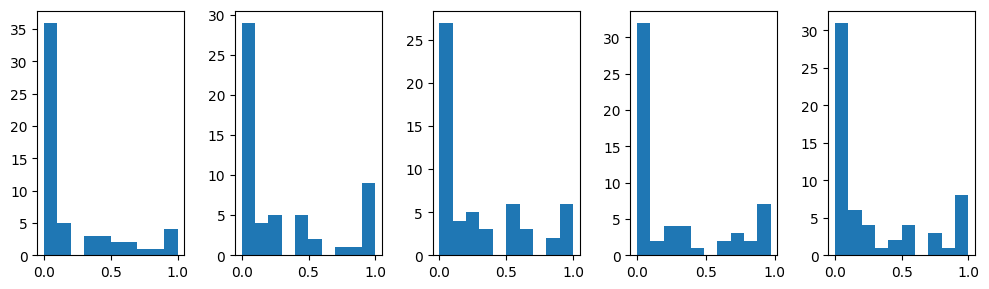

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(10,3))
for n,i in enumerate(range(1,6)):
    ax = axs[n]
    df = pd.read_csv(f"data/breakout/subset{i}_eos4e40.csv")
    ax.hist(df["50uM_Inhibition"])
plt.tight_layout()

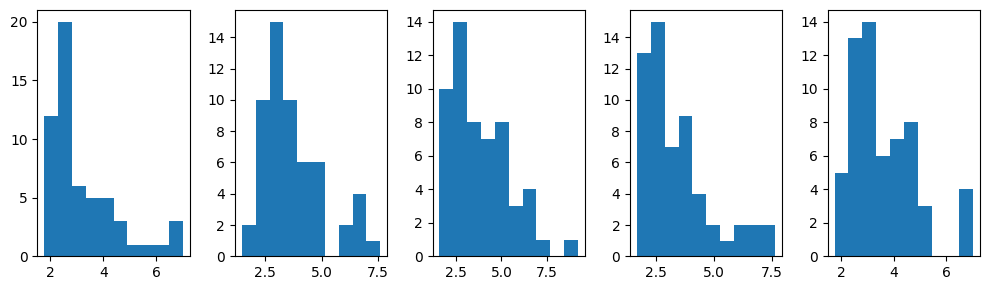

In [33]:
fig, axs = plt.subplots(1,5,figsize=(10,3))
for n,i in enumerate(range(1,6)):
    ax = axs[n]
    df = pd.read_csv(f"data/breakout/subset{i}_eos9ei3.csv")
    ax.hist(df["outcome"])
plt.tight_layout()

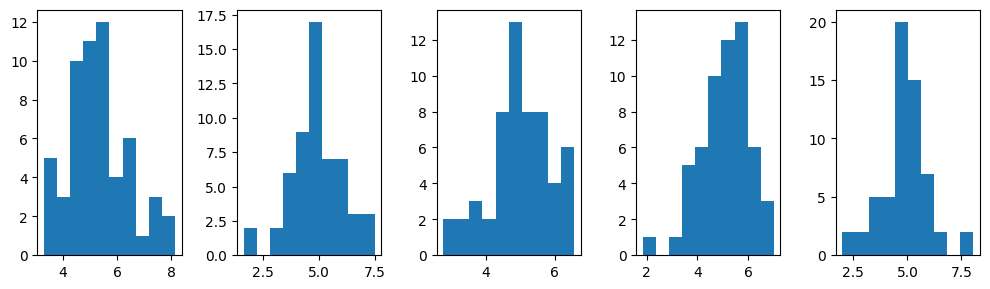

In [34]:
fig, axs = plt.subplots(1,5,figsize=(10,3))
for n,i in enumerate(range(1,6)):
    ax = axs[n]
    df = pd.read_csv(f"data/breakout/subset{i}_eos43at.csv")
    ax.hist(df["pic50"])
plt.tight_layout()

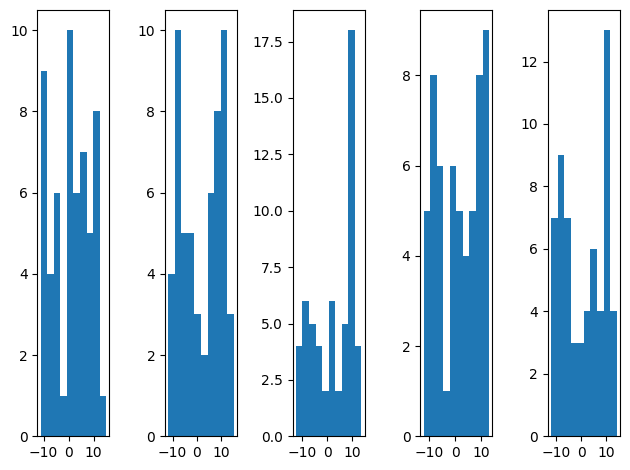

In [36]:
fig, axs = plt.subplots(1,5)
for n,i in enumerate(range(1,6)):
    ax = axs[n]
    df = pd.read_csv(f"data/breakout/subset{i}_eos9yui.csv")
    ax.hist(df["np_score"])
plt.tight_layout()

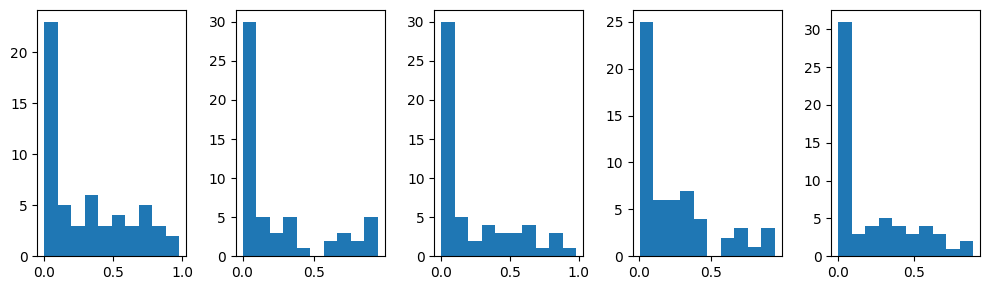

In [37]:
fig, axs = plt.subplots(1,5, figsize=(10,3))
for n,i in enumerate(range(1,6)):
    ax = axs[n]
    df = pd.read_csv(f"data/breakout/subset{i}_eos7d58.csv")
    ax.hist(df["CYP2C19_Veith"])
plt.tight_layout()